In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *
from pycorr import TwoPointCorrelationFunction

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

2024-03-29 19:09:38.973240: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/opt/rhel-7.x86_64/gnu/hdf5/1.12.0/lib:/opt/rhel-7.x86_64/gnu4.9/openmpi/1.10.2/lib:/opt/rhel-7.x86_64/gnu/gsl/2.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
2024-03-29 19:09:38.973285: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 0
nmesh = 1024
cosmology = fiducial.AbacusSummitBase()
z = 0.8

# Mocks
nmocks = 10

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Average density

In [4]:
abacus_halos = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}.npy'.format(z))
abacus_nbar001 = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.001.npy'.format(z))
abacus_nbar003 = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003.npy'.format(z))
abacus_nbar012 = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.012.npy'.format(z))

## Gaussian model

In [5]:
model_linear = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=0.012, damping=False, non_linear=False)
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=0.012, damping=False, non_linear=True)

/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


[000178.82]  03-29 19:12  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/correlation_functions/AbacusSummit_2Gpc_z0.800_2PCF.npy.


/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


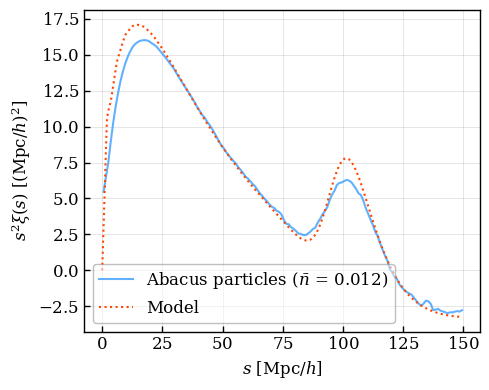

In [6]:
ells = [0]

# Abacus 2PCF
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xi_abacus_halos = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_2PCF.npy'.format(z))
sep, xi_ells_abacus_halos = xi_abacus_halos.get_corr(ells=ells, return_sep=True)

xi_abacus_nbar001 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.001_2PCF.npy'.format(z), allow_pickle=True)
s, xi_ells_abacus_nbar001 = xi_abacus_nbar001.item().get_corr(ells=ells, return_sep=True)

xi_abacus_nbar003 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_2PCF.npy'.format(z), allow_pickle=True)
s, xi_ells_abacus_nbar003 = xi_abacus_nbar003.item().get_corr(ells=ells, return_sep=True)

xi_abacus_nbar012 = np.load(output_dir+'AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.012_2PCF.npy'.format(z), allow_pickle=True)
s, xi_ells_abacus_nbar012 = xi_abacus_nbar012.item().get_corr(ells=ells, return_sep=True)

plt.plot(s, s**2 * xi_ells_abacus_nbar012[0], label=r'Abacus particles ($\bar{n}$ = 0.012)', color='C0', alpha=0.7)
plt.plot(model_linear.sep, model_linear.sep**2 * (np.exp(model_linear.xi) - 1), label=r'Model', ls=':', color='C1')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

## Bias

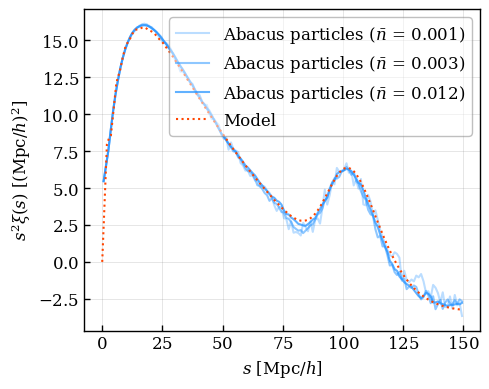

In [7]:
for ill, ell in enumerate(ells):
    #plt.plot(sep, sep**2 * xi_ells_abacus_halos[ill], color='C0', alpha=1.)
    plt.plot(s, s**2 * xi_ells_abacus_nbar001[ill], label=r'Abacus particles ($\bar{n}$ = 0.001)', color='C0', alpha=0.3)
    plt.plot(s, s**2 * xi_ells_abacus_nbar003[ill], label=r'Abacus particles ($\bar{n}$ = 0.003)', color='C0', alpha=0.5)
    plt.plot(s, s**2 * xi_ells_abacus_nbar012[ill], label=r'Abacus particles ($\bar{n}$ = 0.012)', color='C0', alpha=0.7)
    #plt.plot(model.sep, model.sep**2 * 1.485**2 * model.xi, label=r'Model', ls=':', color='C1')
    plt.plot(model.sep, model.sep**2 * model.xi, label=r'Model', ls=':', color='C1')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

## Shot noise

In [8]:
# shot noise correction for xi_R
wfield = model.smoothing_kernel_3D.c2r() / model.boxsize**3
sep, mu, w = project_to_basis(wfield, edges=(model.s, np.array([-1., 1.])), exclude_zero=False)[0][:3]
shotnoise_nbar001 = np.real(w / (abacus_nbar001.size/boxsize**3))
shotnoise_nbar003 = np.real(w / (abacus_nbar003.size/boxsize**3))
shotnoise_nbar012 = np.real(w / (abacus_nbar012.size/boxsize**3))

# shot noise correction for sigma_RR
fourier_kernel = model.smoothing_kernel_3D
norm_fourier_kernel = fourier_kernel / model.boxsize**3
real_space_kernel = norm_fourier_kernel.c2r()
real_space_kernel.value = np.real(real_space_kernel.value)
w2 = integrate_pmesh_field(real_space_kernel**2)
shotnoise_sigma_nbar001 = w2 / (abacus_nbar001.size/boxsize**3)
shotnoise_sigma_nbar003 = w2 / (abacus_nbar003.size/boxsize**3)
shotnoise_sigma_nbar012 = w2 / (abacus_nbar012.size/boxsize**3)

In [9]:
shotnoise_halos = np.real(w / (abacus_halos.size/boxsize**3))

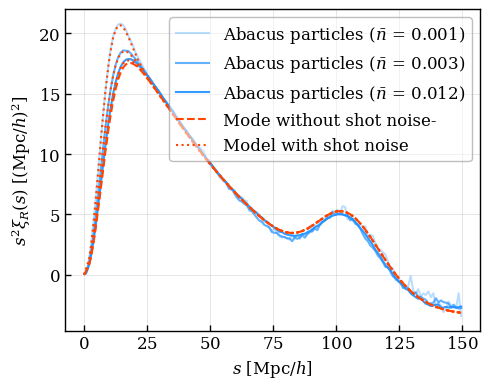

In [10]:
# Abacus smoothed 2PCF
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
xiR_abacus_halos = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
xiR_abacus_nbar001 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.001_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
xiR_abacus_nbar003 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
xiR_abacus_nbar012 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.012_cellsize{:d}_resampler{}_xi_R.npy'.format(cellsize, resampler), allow_pickle=True)
sep, xiR_ells_abacus_halos = xiR_abacus_halos.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_nbar001 = xiR_abacus_nbar001.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_nbar003 = xiR_abacus_nbar003.item().get_corr(ells=ells, return_sep=True)
sep, xiR_ells_abacus_nbar012 = xiR_abacus_nbar012.item().get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    #plt.plot(sep, sep**2 * xiR_ells_abacus_halos[ill], label=r'Abacus halos', color='C0')
    #plt.plot(model.sep, model.sep**2 * 1.485**2 * (model.xi_R), ls=':', color='C1', label='Model (no shot noise)')
    #plt.plot(model.sep, model.sep**2 * 1.485**2 * (model.xi_R + shotnoise_halos), ls='--', color='C1', label='Model (corrected)')
    plt.plot(sep, sep**2 * xiR_ells_abacus_nbar001[ill], label=r'Abacus particles ($\bar{n}$ = 0.001)', color='C0', alpha=0.3)
    plt.plot(sep, sep**2 * xiR_ells_abacus_nbar003[ill], label=r'Abacus particles ($\bar{n}$ = 0.003)', color='C0', alpha=0.7)
    plt.plot(sep, sep**2 * xiR_ells_abacus_nbar012[ill], label=r'Abacus particles ($\bar{n}$ = 0.012)', color='C0', alpha=0.9)
    plt.plot(model.sep, model.sep**2 * (model.xi_R), label=r'Mode without shot noise-', ls='--', color='C1')
    plt.plot(model.sep, model.sep**2 * (model.xi_R + shotnoise_nbar001), label=r'Model with shot noise', ls=':', color='C1')
    plt.plot(model.sep, model.sep**2 * (model.xi_R + shotnoise_nbar003), ls=':', color='C1')
    plt.plot(model.sep, model.sep**2 * (model.xi_R + shotnoise_nbar012), ls=':', color='C1')
    
plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

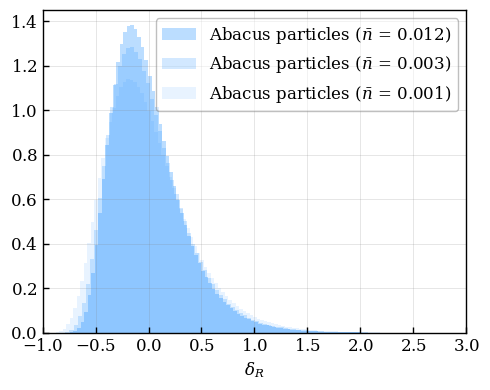

In [11]:
abacus_particles_nbar001_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.001_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_particles_nbar003_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_particles_nbar012_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.012_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))

plt.hist(abacus_particles_nbar012_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.012)')
plt.hist(abacus_particles_nbar003_delta_R, bins=200, density=True, alpha=0.2, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.003)')
plt.hist(abacus_particles_nbar001_delta_R, bins=200, density=True, alpha=0.1, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.001)')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.legend()
plt.show()

In [12]:
def compute_delta0_sigma_from_moments(delta_R, m2=None, m3=None):
    if m2 is None:
        m2 = np.mean(delta_R**2) #moment(delta_R, 2)
    if m3 is None:
        m3 = np.mean(delta_R**3) #moment(delta_R, 3)
    def tomin(delta0):
        return (m3 - 3/delta0 * m2**2 - 1/delta0**3 * m2**3)**2
    res = minimize(tomin, x0=1.)
    print(res)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + m2/res.x[0]**2))
    return delta0, sigma

delta0_nbar001, sigma_nbar001 = compute_delta0_sigma_from_moments(abacus_particles_nbar001_delta_R)
delta0_nbar003, sigma_nbar003 = compute_delta0_sigma_from_moments(abacus_particles_nbar003_delta_R)
delta0_nbar012, sigma_nbar012 = compute_delta0_sigma_from_moments(abacus_particles_nbar012_delta_R)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 8.667295558334294e-12
        x: [ 1.126e+00]
      nit: 6
      jac: [-4.326e-07]
 hess_inv: [[ 8.939e+01]]
     nfev: 16
     njev: 8
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.2987382549221138e-11
        x: [ 9.711e-01]
      nit: 4
      jac: [ 4.803e-07]
 hess_inv: [[ 1.174e+02]]
     nfev: 14
     njev: 7
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.4512248199253881e-10
        x: [ 8.714e-01]
      nit: 4
      jac: [ 1.595e-06]
 hess_inv: [[ 1.179e+02]]
     nfev: 18
     njev: 9


In [13]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

delta = np.linspace(-1, 4, 200)

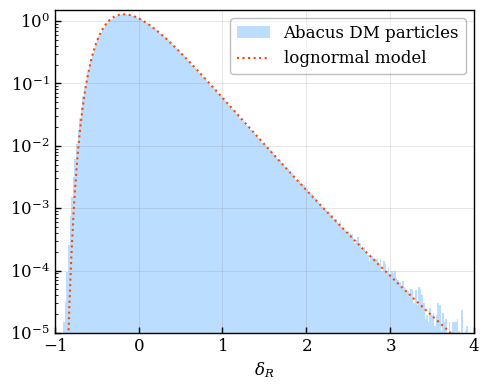

In [14]:
abacus_particles_nbar001_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.001_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_particles_nbar003_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))
abacus_particles_nbar012_delta_R = np.load('/feynman/work/dphp/mp270220/outputs/density/AbacusSummit_2Gpc_z{:.3f}_downsampled_particles_nbar0.012_cellsize{:d}_resampler{}_delta_R.npy'.format(z, cellsize, resampler))

#pdf_nbar012 = plt.hist(abacus_particles_nbar012_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.012)')
pdf_nbar003 = plt.hist(abacus_particles_nbar003_delta_R, bins=400, density=True, alpha=0.3, color='C0', label=r'Abacus DM particles')
#pdf_nbar001 = plt.hist(abacus_particles_nbar001_delta_R, bins=200, density=True, alpha=0.2, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.001)')
#plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar001, delta0_nbar001), color='C1', ls=':', label=r'lognormal model')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar003, delta0_nbar003), color='C1', ls=':', label='lognormal model')
#plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar012, delta0_nbar012), color='C1', ls=':')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
plt.yscale('log')
plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00038778676710305343
        x: [ 1.171e+00]
      nit: 6
      jac: [-2.314e-06]
 hess_inv: [[ 3.761e-01]]
     nfev: 16
     njev: 8
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0012389164091360359
        x: [ 9.994e-01]
      nit: 5
      jac: [ 1.798e-06]
 hess_inv: [[ 2.398e-01]]
     nfev: 14
     njev: 7
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0010600212520722387
        x: [ 8.916e-01]
      nit: 3
      jac: [ 2.527e-07]
 hess_inv: [[ 1.354e-01]]
     nfev: 10
     njev: 5


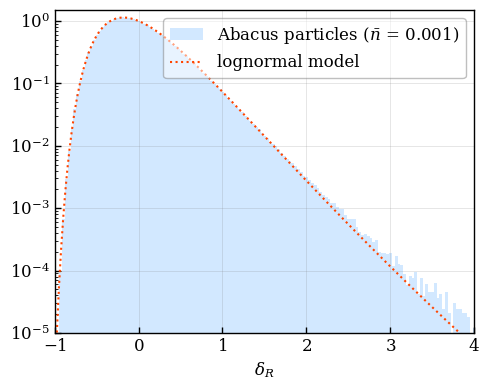

In [20]:
def to_minimize(delta0, *args):
    shotnoise = args[2]
    sigma = np.sqrt(np.log(1 + (model.sigma_RR**2 + shotnoise)/delta0**2))
    x = args[0]
    y = friedrich_lognormal_model((args[1][1:]+args[1][:-1])/2., sigma, delta0)
    return np.sum((x-y)**2)

def compute_bestfit_delta0(delta_R_pdf, return_sigma=True, shotnoise=0):
    res = minimize(to_minimize, x0=0.9, args=(delta_R_pdf[0], delta_R_pdf[1], shotnoise))
    print(res)
    delta0 = res.x[0]
    sigma = np.sqrt(np.log(1 + (model.sigma_RR**2 + shotnoise)/delta0**2))
    return delta0, sigma
    
delta0_nbar001_2, sigma_nbar001_2 = compute_bestfit_delta0(pdf_nbar001, shotnoise=shotnoise_sigma_nbar001)
delta0_nbar003_2, sigma_nbar003_2 = compute_bestfit_delta0(pdf_nbar003, shotnoise=shotnoise_sigma_nbar003)
delta0_nbar012_2, sigma_nbar012_2 = compute_bestfit_delta0(pdf_nbar012, shotnoise=shotnoise_sigma_nbar012)

#plt.hist(abacus_particles_nbar012_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.012)')
#plt.hist(abacus_particles_nbar003_delta_R, bins=200, density=True, alpha=0.2, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.003)')
plt.hist(abacus_particles_nbar001_delta_R, bins=200, density=True, alpha=0.2, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.001)')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar001_2, delta0_nbar001_2), color='C1', ls=':', label=r'lognormal model')
#plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar003_2, delta0_nbar003_2), color='C1', ls=':')
#plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar012_2, delta0_nbar012_2), color='C1', ls=':')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 4))
plt.yscale('log')
plt.ylim((1e-5, 1.5))
plt.legend()
plt.show()

In [21]:
sigma_nbar012_2, delta0_nbar012_2

(array([0.37386791]), 0.8915753157239796)

In [22]:
np.linspace(0, 1, 5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [23]:
scipy.stats.lognorm.ppf([0, 1./3, 2./3, 1], sigma_nbar003, -delta0_nbar003, delta0_nbar003*np.exp(-sigma_nbar003**2/2.))

array([-0.97111937, -0.19549491,  0.09217823,         inf])

In [24]:
scipy.stats.lognorm.ppf([0, 1./5, 2./5, 3./5, 4./5, 1], sigma_nbar003, -delta0_nbar003, delta0_nbar003*np.exp(-sigma_nbar003**2/2.))

array([-0.97111937, -0.30384557, -0.14344111,  0.02530601,  0.26483449,
               inf])

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.000338305047188046
        x: [ 1.173e+00  3.347e-01]
      nit: 10
      jac: [-1.786e-07 -6.788e-07]
 hess_inv: [[ 4.145e-01 -1.228e-01]
            [-1.228e-01  3.900e-02]]
     nfev: 39
     njev: 13
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0007642678078347296
        x: [ 1.005e+00  3.514e-01]
      nit: 6
      jac: [ 5.310e-07  1.830e-06]
 hess_inv: [[ 2.859e-01 -1.051e-01]
            [-1.051e-01  4.165e-02]]
     nfev: 30
     njev: 10
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.000633108938636428
        x: [ 8.955e-01  3.707e-01]
      nit: 6
      jac: [ 6.364e-07  3.585e-07]
 hess_inv: [[ 1.486e-01 -6.457e-02]
            [-6.457e-02  3.070e-02]]
     nfev: 30
     njev: 10


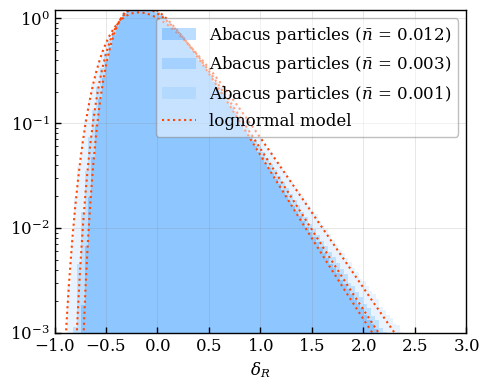

In [25]:
def to_minimize(params, *args):
    pdf = args
    delta0 = params[0]
    sigma = params[1]
    x = pdf[0]
    y = friedrich_lognormal_model((pdf[1][1:]+pdf[1][:-1])/2., sigma, delta0)
    return np.sum((x-y)**2)

def compute_bestfit_delta0_sigma(delta_R_pdf):
    res = minimize(to_minimize, x0=np.array([0.9, model.sigma_RR[0]]), args=delta_R_pdf)
    print(res)
    delta0 = res.x[0]
    sigma = res.x[1]
    return delta0, sigma
    
delta0_nbar001_3, sigma_nbar001_3 = compute_bestfit_delta0_sigma(pdf_nbar001)
delta0_nbar003_3, sigma_nbar003_3 = compute_bestfit_delta0_sigma(pdf_nbar003)
delta0_nbar012_3, sigma_nbar012_3 = compute_bestfit_delta0_sigma(pdf_nbar012)

plt.hist(abacus_particles_nbar012_delta_R, bins=200, density=True, alpha=0.3, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.012)')
plt.hist(abacus_particles_nbar003_delta_R, bins=200, density=True, alpha=0.2, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.003)')
plt.hist(abacus_particles_nbar001_delta_R, bins=200, density=True, alpha=0.1, color='C0', label=r'Abacus particles ($\bar{n}$ = 0.001)')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar001_3, delta0_nbar001_2), color='C1', ls=':', label=r'lognormal model')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar003_3, delta0_nbar003_3), color='C1', ls=':')
plt.plot(delta, friedrich_lognormal_model(delta, sigma_nbar012_3, delta0_nbar012_3), color='C1', ls=':')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1, 3))
plt.yscale('log')
plt.ylim((0.001, 1.2))
plt.legend()
plt.show()

## Lognormal model for density splits

In [26]:
nsplits = 3
th_bins = np.array([-1., -0.18346272,  0.09637895, np.inf])

In [27]:
def compute_main_term(delta, sigma, delta0=1., delta0_R=1., bias=1., xi_R=None, shotnoise=None):
    if xi_R is None:
        xi_R = model.xi_R * bias**2
        if shotnoise is not None:
            xi_R = (model.xi_R + shotnoise) * bias**2
    if math.isfinite(delta):
        a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
        b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))
    else:
        if delta > 0:
            a = np.full_like(model.xi_R, 1)
            b = np.full_like(model.xi_R, 1)
        if delta < 0:
            a = np.full_like(model.xi_R, -1)
            b = np.full_like(model.xi_R, -1)
    return a, b

def compute_dsplits(sigma, delta0=1., delta0_R=1., th_bins=th_bins, bias=1., xi_R=None, shotnoise=None):
    dsplits = list()

    for i in range(len(th_bins)-1):
        d1 = max(th_bins[i], -delta0_R)
        d2 = th_bins[i+1]
        a1, b1 = compute_main_term(d1, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        a2, b2 = compute_main_term(d2, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        main_term = (a2 - a1) / (b2 - b1)
        dsplits.append(delta0*(main_term - 1))

    return dsplits

/tmp/ipykernel_1618521/1906400520.py:7: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
/tmp/ipykernel_1618521/1906400520.py:8: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))


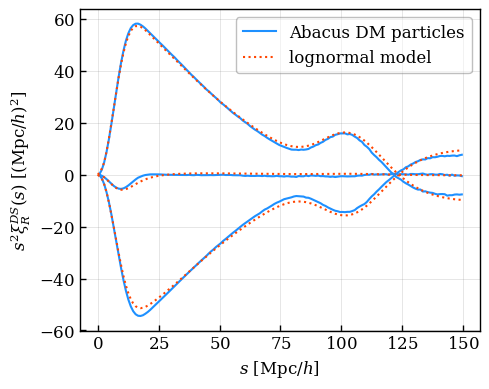

In [46]:
dsplits_nbar001 = compute_dsplits(sigma=sigma_nbar001, delta0=1., delta0_R=delta0_nbar001, bias=1., xi_R=None, shotnoise=shotnoise_nbar001)
dsplits_nbar003 = compute_dsplits(sigma=sigma_nbar003, delta0=1., delta0_R=delta0_nbar003, bias=1., xi_R=None, shotnoise=shotnoise_nbar003)
dsplits_nbar012 = compute_dsplits(sigma=sigma_nbar012, delta0=1., delta0_R=delta0_nbar012, bias=1., xi_R=None, shotnoise=shotnoise_nbar012)

split_xi_abacus_particles_nbar001 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.001_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_particles_nbar001 = split_xi_abacus_particles_nbar001.item()['rh']
split_xi_ells_abacus_particles_nbar001 = [split_xi_abacus_particles_nbar001[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_particles_nbar001[0].get_corr(ells=ells, return_sep=True)

split_xi_abacus_particles_nbar003 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.003_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_particles_nbar003 = split_xi_abacus_particles_nbar003.item()['rh']
split_xi_ells_abacus_particles_nbar003 = [split_xi_abacus_particles_nbar003[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_particles_nbar003[0].get_corr(ells=ells, return_sep=True)

split_xi_abacus_particles_nbar012 = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar0.012_cellsize{:d}_resampler{}_{:d}splits_randoms_size4'.format(cellsize, resampler, nsplits)+'_RH_CCF.npy', allow_pickle=True)
split_xi_abacus_particles_nbar012 = split_xi_abacus_particles_nbar012.item()['rh']
split_xi_ells_abacus_particles_nbar012 = [split_xi_abacus_particles_nbar012[ds].get_corr(ells=ells) for ds in range(nsplits)]
sep, _ = split_xi_abacus_particles_nbar012[0].get_corr(ells=ells, return_sep=True)

for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        #plt.plot(sep, sep**2 * split_xi_ells_abacus_particles_nbar001[ds][0], label=r'DS{}'.format(ds+1), ls='-', color='C0', alpha=1)
        plt.plot(sep, sep**2 * split_xi_ells_abacus_particles_nbar003[ds][0], ls='-', color='C0', alpha=1)
        #plt.plot(sep, sep**2 * split_xi_ells_abacus_particles_nbar012[ds][0], label=r'DS{}'.format(ds+1), ls='-', color='C0', alpha=1)
        #plt.plot(model.sep, model.sep**2 * dsplits_nbar001[ds], label='Lognormal model', ls=':', color='C1')
        plt.plot(model.sep, model.sep**2 * dsplits_nbar003[ds], ls=':', color='C1')
        #plt.plot(model.sep, model.sep**2 * dsplits_nbar012[ds], label='Lognormal model', ls=':', color='C1')

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

plt.plot([], [], label=r'Abacus DM particles', ls='-', color='C0', alpha=1)
#plt.plot([], [], label=r'Abacus particles ($\bar{n}$ = 0.003)', ls='-', color='C0', alpha=0.7)
#plt.plot([], [], label=r'Abacus particles ($\bar{n}$ = 0.012)', ls='-', color='C0', alpha=0.9)
plt.plot([], [], label=r'lognormal model', ls=':', color='C1', alpha=1)

#first_legend = plt.legend(handles=lines, loc='lower right')
plt.legend(loc='upper right')

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()